In [1]:
import sys,os
import obspy
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.trigger import recursive_sta_lta_py
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.transforms as mtransforms
import pygmt
import csv
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import time
import multiprocessing as mp

########### 
import bp_lib
import math
def calculate_shear_mach_front_angle(super_shear_velocity):
    # Calculate the shear Mach front angle using the super-shear velocity
    sin_shear_mach_front_angle = 1 / super_shear_velocity
    shear_mach_front_angle = math.degrees(math.asin(sin_shear_mach_front_angle))
    return shear_mach_front_angle
def moving_average(x, w):
    """
    Computes the moving average of a 2D numpy array x with a window size of w.
    """
    return np.convolve(x, np.ones(w), 'same') / w


In [2]:
name='MYR_7.7_AU_10.0km_iasp91_0.6_corr_0.1_grid'
path = os.getcwd()
outdir = name #str(Event)+'_'+str(Exp_name)




In [3]:
input = pd.read_csv('./'+name+'/input.csv',header=None)
a=input.to_dict('series')
keys = a[0][:]
values = a[1][:]
res = {}
for i in range(len(keys)):
        res[keys[i]] = values[i]
        #print(keys[i],values[i])
bp_l                = float(res['bp_l']) #Hz
bp_u                = float(res['bp_u'])   #Hz
bp_l                = 0.8 #Hz
bp_u                = 2.0   #Hz

smooth_time_window  = int(res['smooth_time_window'])   #seconds
smooth_space_window = int(res['smooth_space_window'])
stack_start         = int(res['stack_start'])   #in seconds
stack_end           = int(res['stack_end'])  #in seconds
STF_start           = int(res['STF_start'])
STF_end             = int(res['STF_end'])
sps                 = int(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])

##########################################################################
# Event info
Event=res['Event']
event_lat=float(res['event_lat'])
event_long=float(res['event_long'])
event_depth=float(res['event_depth'])
Array_name=res['Array_name']
#Exp_name=res['Exp_name']
azimuth_min=float(res['azimuth_min'])
azimuth_max=float(res['azimuth_max'])
dist_min=float(res['dist_min'])
dist_max=float(res['dist_max'])
origin_time=obspy.UTCDateTime(int(res['origin_year']),int(res['origin_month']),
             int(res['origin_day']),int(res['origin_hour']),int(res['origin_minute']),float(res['origin_seconds']))
print(origin_time)
Focal_mech = dict(strike=float(res['event_strike']), dip=float(res['event_dip']), rake=float(res['event_rake'])
                 , magnitude=float(res['event_magnitude']))
model               = TauPyModel(model=str(res['model']))
sps                 = int(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
#smooth_time_window  = int((stack_end-stack_start)/10) #int(res['smooth_time_window'])   #seconds
source_grid_size    = float(res['source_grid_size']) #degrees
source_grid_extend_x  = float(res['source_grid_extend_x'])   #degrees
source_grid_extend_y  = float(res['source_grid_extend_y']) 
source_depth_size   = float(res['source_depth_size']) #km
source_depth_extend = float(res['source_grid_extend']) #km

#stream_for_bp=obspy.read('./Turky_7.6_all/stream.mseed')
slong,slat          = bp_lib.make_source_grid_hetero(event_long,event_lat,source_grid_extend_x,source_grid_extend_y,source_grid_size)


beam_file='beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
print('Beam file in :',beam_file)
stations_file = str(res['stations'])
stream_for_bp= obspy.read('./'+name+'/stream.mseed') 
beam = np.loadtxt('./'+name+'/'+beam_file)
beam_i = np.load('./'+name+'/beam_info.npy',allow_pickle=True)

stream_info = np.load('./'+name+'/array_bp_info.npy',allow_pickle=True)
print('#############################################################################\n')
print('Exp:',name)
print('Origin time:',origin_time)
print('Long= %f Lat= %f Depth= %f' % (event_long,event_lat,event_depth))
#print('bp_low= %f bp_high= %f Correlation threshold= %f SNR= %f'% (bp_l,bp_u,threshold_correlation,SNR))
print('#############################################################################\n')


sta_name=list(stream_info[:,1])
for t in stream_for_bp:
        if len(t.stats['station'].split('.')) > 1:
            sta          = t.stats.station+str('H')
        else:
            sta          = t.stats.station
        #net 
        if sta in sta_name:
            ind                          = sta_name.index(sta)
            t.stats['origin_time']       = origin_time
            t.stats['station_longitude'] = float(stream_info[ind,2])
            t.stats['station_latitude']  = float(stream_info[ind,3])
            t.stats['Dist']              = float(stream_info[ind,4])
            t.stats['Azimuth']           = float(stream_info[ind,5])
            arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=t.stats.Dist,phase_list=["P"])
            arr                          = arrivals[0]
            t_travel                     = arr.time;
            t.stats['P_arrival']         = origin_time + t_travel 
        
            #t.stats['P_arrival']         = float(stream_info[ind,6]) 
            t.stats['Corr_coeff']        = float(stream_info[ind,7])
            t.stats['Corr_shift']        = float(stream_info[ind,8])
            t.stats['Corr_sign']         = float(stream_info[ind,9])
        else:
            pass
            #print('Something is not right.')


Ref_station_index=bp_lib.get_ref_station(stream_for_bp)
ref_trace = stream_for_bp[Ref_station_index]

for tr in stream_for_bp:
    count=0;
    for tr_ in stream_for_bp:
        dist=((tr.stats.station_latitude-tr_.stats.station_latitude)**2 + 
              (tr.stats.station_longitude-tr_.stats.station_longitude)**2 )**0.2;
        if ( dist <= 1):
            count=count+1;
        else:
            continue
    tr.stats['Station_weight'] = count

print('Done loading data')

2025-03-28T06:20:52.000000Z
Beam file in : beam_0.8_2.0_AU.dat
#############################################################################

Exp: MYR_7.7_AU_10.0km_iasp91_0.6_corr_0.1_grid
Origin time: 2025-03-28T06:20:52.000000Z
Long= 95.925800 Lat= 21.996300 Depth= 10.000000
#############################################################################

Done loading data


In [4]:
smooth_space_window=1
smooth_time_window=1
beam_smoothened_=np.zeros_like(beam)
m,n=np.shape(beam_smoothened_)
#space
for i in range(m):
    beam_smoothened_[:][i]=moving_average(beam[:][i],smooth_space_window)
#time
for i in range(m):
    beam_smoothened_[i][:]=moving_average(beam[i][:],smooth_time_window*sps)
#beam_smoothened=beam_smoothened/np.max(beam_smoothened)
beam_smoothened=np.square(beam_smoothened_)/np.max(np.square(beam_smoothened_))
print('Maximum energy of the beam:',np.max(beam_smoothened))
#plt.plot(moving_average(beam_reshaped[:][10],10*sps))

Maximum energy of the beam: 1.0


Size of STF: (4600,)
Size of STF: (3000,)
Size of the cumulative energy: (3200,)
Maximum energy of the cumulative energy: 1.0
Maximum energy of the beam: 1.0
Size of the peak energy: (150, 4)
Maximum energy of the peaks: 1.0


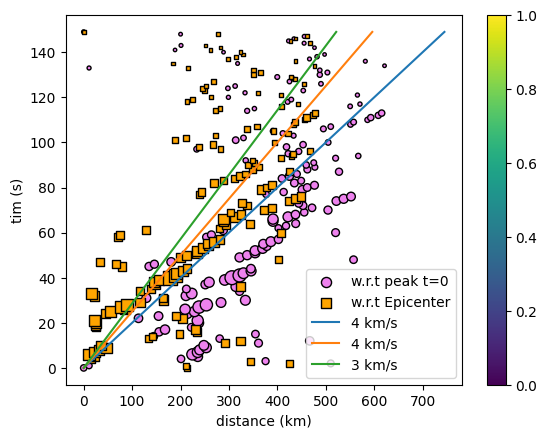

In [5]:
stf_beam      = np.sum(beam_smoothened,axis=0)
#stf_beam      = np.sum(beam_reshaped,axis=0)

print('Size of STF:', np.shape(stf_beam))
#Taking square becaouse we are interested in the power
#stf_beam=stf_beam**2
stf_beam=stf_beam[(STF_start+stack_start)*sps:(STF_end+stack_start)*sps]
stf_beam=stf_beam/np.max(stf_beam)
print('Size of STF:', np.shape(stf_beam))

stf_beam=np.column_stack((stf_beam,range(len(stf_beam))))
stf_beam[:,1]=stf_beam[:,1]/sps
#plt.plot(stf_beam[:,1],stf_beam[:,0])
file_save    = 'STF_beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_time_window)+'.dat'
np.savetxt(outdir+'/'+file_save,stf_beam,header='energy(normalized) time(s) ')  

# Cumulative energy
beam_cumulative_use=beam_smoothened.T
temp     =np.sum(beam_cumulative_use[(STF_start+stack_start)*sps:(STF_end+stack_start)*sps],axis=0)
#temp     =np.sum(beam_smoothened,axis=1)
print('Size of the cumulative energy:',np.shape(temp))
np.size(temp)
m,n=np.shape(beam_smoothened)
cumulative_energy=np.zeros((m,3))
cumulative_energy[:,2]=temp #/np.max(temp)
cumulative_energy[:,0]=slong
cumulative_energy[:,1]=slat

cumulative_energy[:,2]=cumulative_energy[:,2]/np.max(cumulative_energy[:,2])

file_save='cumulative_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_time_window)+'.dat'
np.savetxt(outdir+'/'+file_save,cumulative_energy,header='long lat energy(normalized)')

print('Maximum energy of the cumulative energy:',np.max(cumulative_energy[:,2]))

beam_peak_energy_use=beam_smoothened.T[(STF_start+stack_start)*sps:(STF_end+stack_start)*sps]
print('Maximum energy of the beam:',np.max(beam_peak_energy_use))
m,n=np.shape(beam_peak_energy_use)
peak_energy=np.zeros((int(m/sps),4))
print('Size of the peak energy:',np.shape(peak_energy))
for i in range(len(peak_energy)):
    ind              = np.argmax(beam_peak_energy_use[i*sps])
    peak_energy[i,0] = i
    peak_energy[i,1] = slong[ind]
    peak_energy[i,2] = slat[ind]
    #peak_energy[i,3] = beam_smoothened[ind][i]
    peak_energy[i,3] = beam_peak_energy_use[i*sps][ind]
    #print(beam_peak_energy_use[i][ind])
peak_energy[:,3]=peak_energy[:,3]/np.max(peak_energy[:,3])
print('Maximum energy of the peaks:',np.max(peak_energy[:,3]))

dist_rupture=np.zeros(len(peak_energy))
dist_rupture2=np.zeros(len(peak_energy))
dist_rupture3=np.zeros(len(peak_energy))

for i in range(len(dist_rupture)-1):
    dist_rupture[i]= np.sqrt(((peak_energy[i,1]-event_long)**2 + (peak_energy[i,2]-event_lat)**2))*(111)
    dist_rupture2[i]= np.sqrt(((peak_energy[i,1]-peak_energy[0,1])**2 + (peak_energy[i,2]-peak_energy[0,2])**2))*(111)
    dist_rupture3[i]= np.sqrt(((peak_energy[i,1]-peak_energy[i+1,1])**2 + (peak_energy[i,2]-peak_energy[i+1,2])**2))*(111)

peak_energy=np.column_stack((peak_energy,dist_rupture))
peak_energy=np.column_stack((peak_energy,dist_rupture2))
peak_energy=np.column_stack((peak_energy,np.cumsum(dist_rupture2)))

file_save='Peak_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_time_window)+'.dat'
np.savetxt(outdir+'/'+file_save,peak_energy,header='time(s) long lat energy(normalized) distance_wrt_epiceter(km) distance_peaks(km)')

plt.scatter(x=dist_rupture2[:], y=peak_energy[:,0],s=peak_energy[:,3]*100,c='violet',
            label='w.r.t peak t=0',marker='o',edgecolors='black')
plt.scatter(x=dist_rupture[:], y=peak_energy[:,0],s=peak_energy[:,3]*100,c='orange',
            label='w.r.t Epicenter',marker='s',edgecolors='black')
#plt.scatter(x=np.cumsum(dist_rupture3[:]), y=peak_energy[:,0],s=peak_energy[:,3]*100,c=peak_energy[:,3],cmap='magma',
#            label='w.r.t Epicenter',marker='*')
#plt.plot(np.gradient(dist_rupture), peak_energy[st:end,0])
#plt.plot(10*peak_energy[st:end,0],peak_energy[st:end,0],label='10 km/s')
plt.plot(5.0*peak_energy[:,0],peak_energy[:,0],label='4 km/s')
plt.plot(4.0*peak_energy[:,0],peak_energy[:,0],label='4 km/s')
plt.plot(3.5*peak_energy[:,0],peak_energy[:,0],label='3 km/s')
#plt.plot(1*peak_energy[st:end,0],peak_energy[st:end,0],label='1.0 km/s')
plt.xlabel('distance (km)')
plt.ylabel('tim (s)')
plt.legend()
plt.colorbar()
plt.savefig(outdir+'/'+str(name)+'_Rupture_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.png')


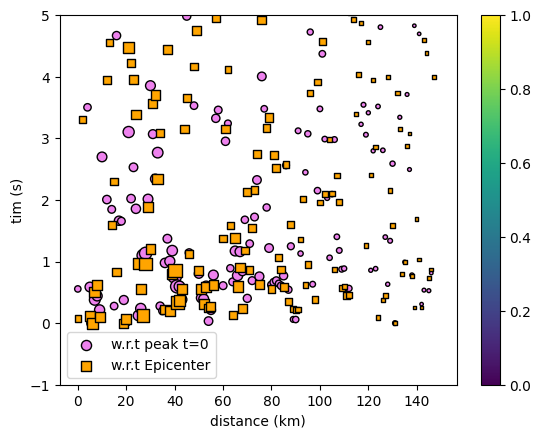

In [6]:
plt.scatter(y=np.abs(np.gradient(dist_rupture2[:],peak_energy[:,0]*sps)), x=peak_energy[:,0],s=peak_energy[:,3]*100,c='violet',
            label='w.r.t peak t=0',marker='o',edgecolors='black')
plt.scatter(y=np.abs(np.gradient(dist_rupture[:],peak_energy[:,0]*sps)), x=peak_energy[:,0],s=peak_energy[:,3]*100,c='orange',
            label='w.r.t Epicenter',marker='s',edgecolors='black')
#plt.scatter(x=np.cumsum(dist_rupture3[:]), y=peak_energy[:,0],s=peak_energy[:,3]*100,c=peak_energy[:,3],cmap='magma',
#            label='w.r.t Epicenter',marker='*')
#plt.plot(np.gradient(dist_rupture), peak_energy[st:end,0])
#plt.plot(10*peak_energy[st:end,0],peak_energy[st:end,0],label='10 km/s')
#plt.plot(4.5*peak_energy[:,0],peak_energy[:,0],label='4.5 km/s')
#plt.plot(4*peak_energy[:,0],peak_energy[:,0],label='4 km/s')
#plt.plot(2*peak_energy[:,0],peak_energy[:,0],label='2.5 km/s')
#plt.plot(1*peak_energy[st:end,0],peak_energy[st:end,0],label='1.0 km/s')
plt.ylim(-1,5)
plt.xlabel('distance (km)')
plt.ylabel('tim (s)')
plt.legend()
plt.colorbar()

plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +S<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +S<size> is used. Option -l ignored.


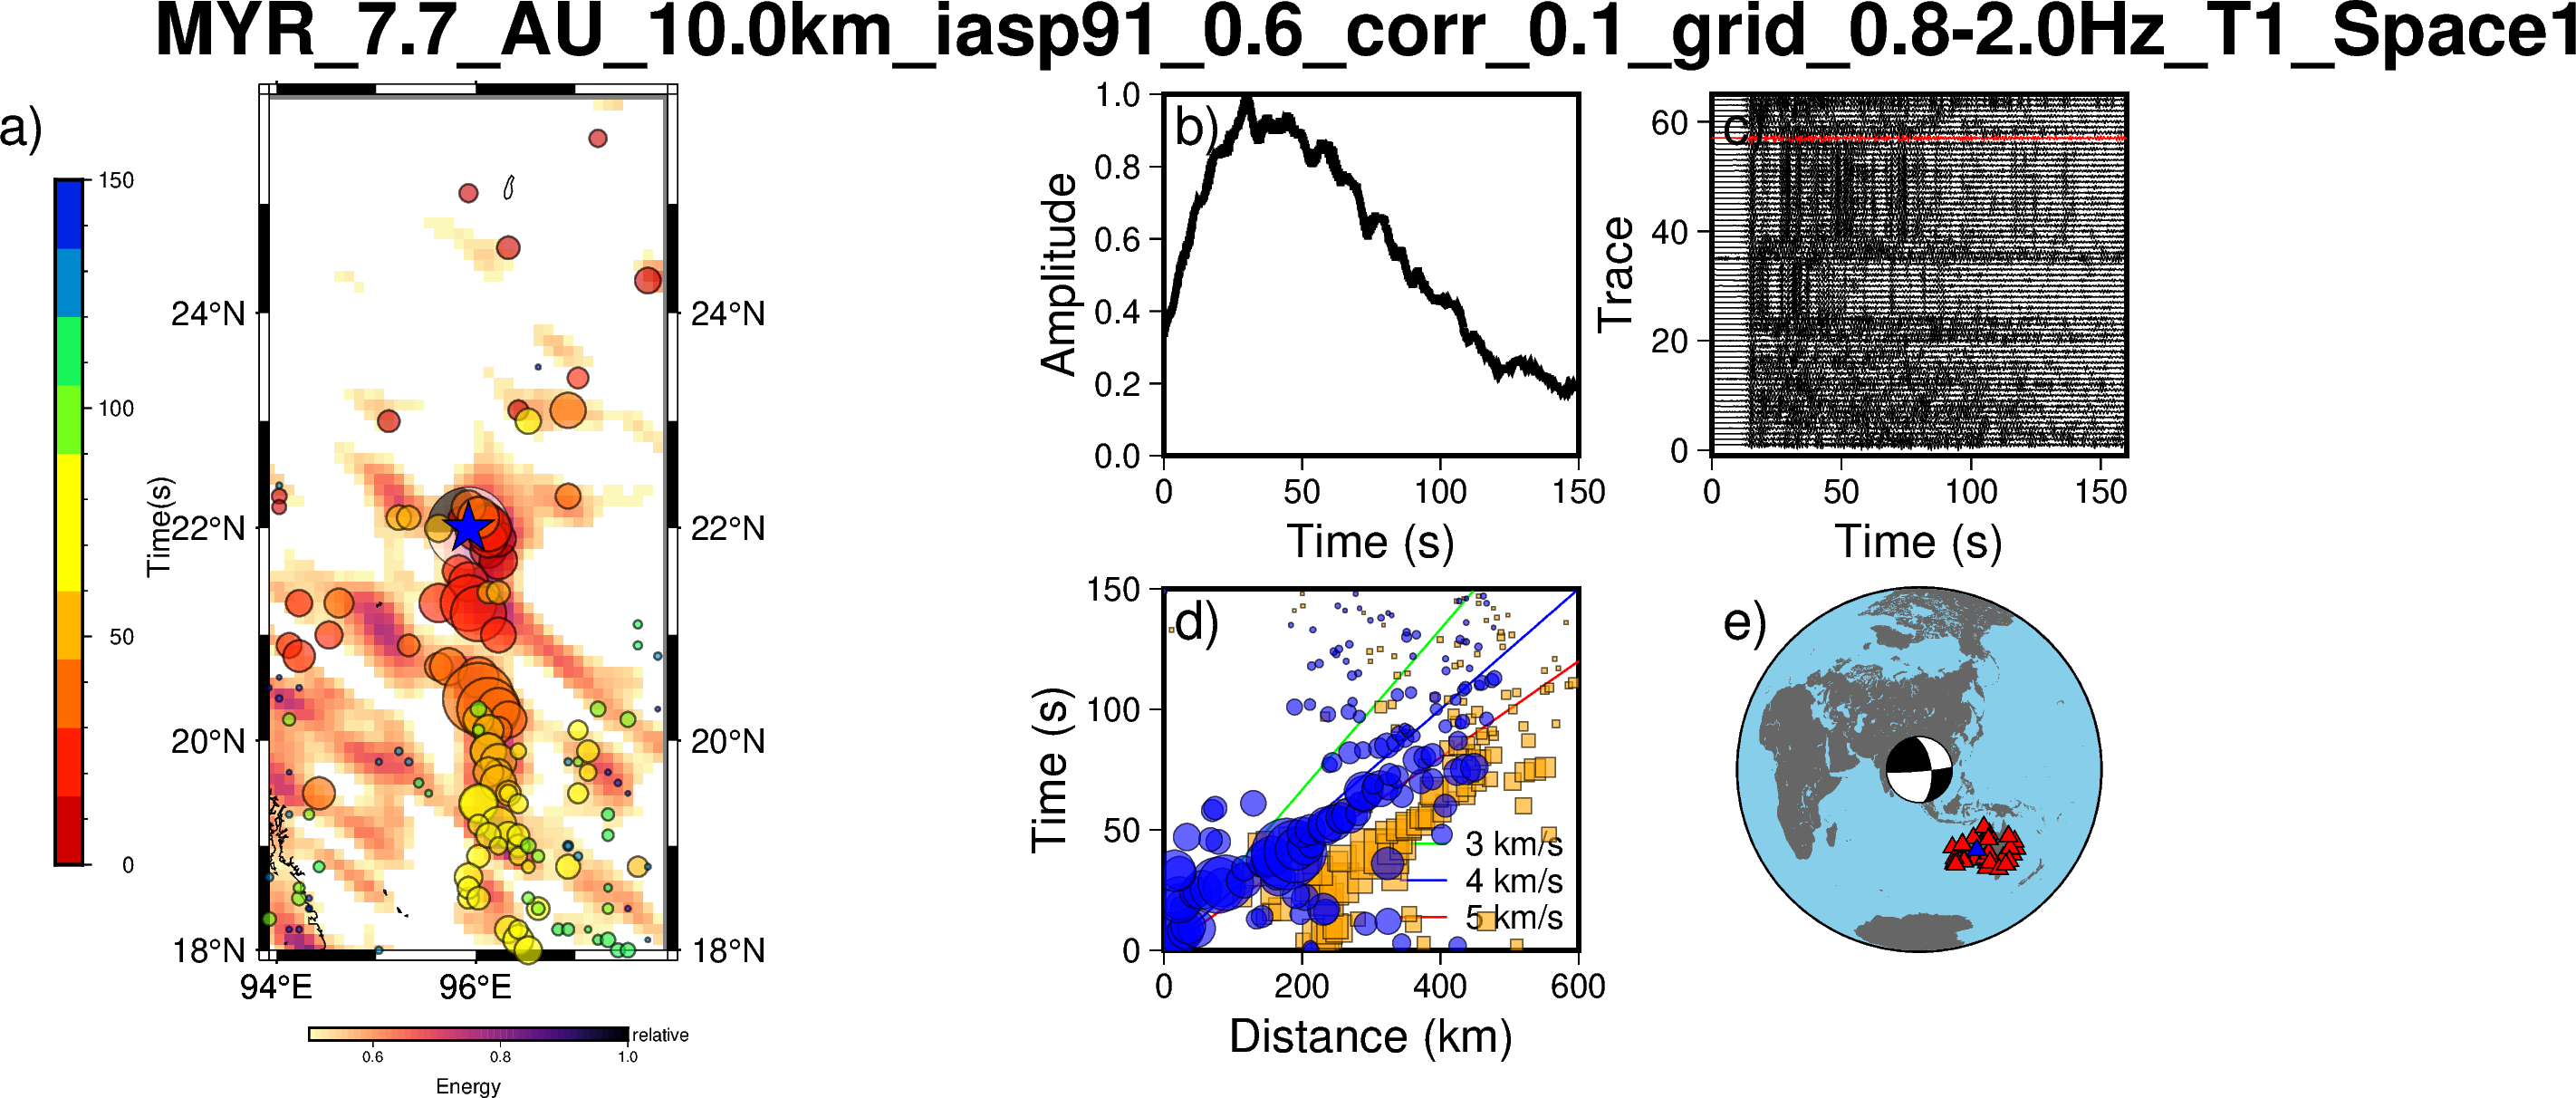

In [7]:
scale=1.5
stream_for_plot=stream_for_bp.copy()
#aftershock=pd.read_csv('./data/Melgar_et_al_model/zenodo/aftershocks.xlsx')
try:
    aftershock_orig=pd.read_csv('./data/USGS_use.csv')
    aftershock= aftershock_orig.loc[(aftershock_orig['relative_time'] <= 32835.731) & (aftershock_orig['mag'] >= 0.0) ]
    aftershock_melgar=pd.read_csv('./data/Melgar_et_al_model/zenodo/Aftershocks_Melgar_et_al_2023.csv')
    #aftershock_dd=pd.read_csv('./data/Melgar_et_al_model/zenodo/aftershocks.csv')
    #faults = geopd.read_file('./data/Turkey_Emergency_EQ_Data/Turkey_Emergency_EQ_Data/simple_fault_2023-03-15/simple_fault_2023-3-15.shp')
except:
    pass
region=[event_long-source_grid_extend_x,event_long+source_grid_extend_x,
        event_lat-source_grid_extend_y,event_lat+source_grid_extend_y]

#region=[35.5,39,36,39]
#region=[35.5,39.5,36,38.5]
title="+t"+name+'_'+str(bp_l)+'-'+str(bp_u)+'Hz_T'+str(smooth_time_window)+'_Space'+str(smooth_time_window)
sta_lat=[]
sta_long=[]
for tr in stream_for_bp:
    sta_lat.append(tr.stats.station_latitude)
    sta_long.append(tr.stats.station_longitude)
spacing=source_grid_size
fig = pygmt.Figure()
figsize=("9c", "8c")
proj="M?"
#########################################################################################################################################
# Plotting rupture map
#########################################################################################################################################
#########################################################################################################################################
# Plotting rupture map
#########################################################################################################################################
with fig.subplot(nrows=1, ncols=1, figsize=figsize, autolabel="a)",
    sharey=False,
    sharex=False,):
    energy_cmap=pygmt.makecpt(cmap="magma", reverse=True,series=[0.5, 1, 0.01])
    df = pygmt.blockmean(data=cumulative_energy, region=region, spacing=spacing)
    grd = pygmt.xyz2grd(data=df, region=region, spacing=spacing)
    fig.grdimage(grid=grd,cmap=energy_cmap,projection=proj, region=region, frame=["af", "wSnE"],\
                 panel=[0, 0])
    fig.colorbar(frame=["a0.2", "x+lEnergy", "y+lrelative"])
    fig.coast(shorelines=True,frame=True,)
    
    #fig.plot(x=aftershock[:,1],y=aftershock[:,0],size=aftershock[:,3]/20,style='cc',fill = 'red',pen='black',)
    #fig.plot(x=aftershock['longitude'],y=aftershock['latitude'],projection=proj,region=region,size=aftershock['mag']/50,style='cc',fill = 'red',pen='black',transparency=60)
    try:
        fig.plot(x=aftershocks['Lon'],y=aftershocks['Lat'],size=aftershocks['Mag']/50,style='cc',fill = 'black',pen='black')#,transparency=0)
    except:
        pass
    fig.meca(spec=Focal_mech,projection=proj,region=region,scale="0.5c", longitude=event_long,latitude=event_lat,depth=event_depth,transparency=40,)
    peak_cmap=pygmt.makecpt(cmap="seis", series=[STF_start, STF_end,  (STF_end-STF_start)/10])
    fig.plot(x=peak_energy[STF_start:STF_end,1],y=peak_energy[STF_start:STF_end,2],projection=proj,region=region, \
             fill=peak_energy[STF_start:STF_end,0],cmap=True, \
         no_clip=True,size=peak_energy[STF_start:STF_end,3]/scale,style='cc', pen='0.5p,black',transparency=40,)
    #fig.plot(x=peak_energy[:,1],y=peak_energy[:,2],projection=proj,region=region, \
    #         fill=peak_energy[:,0],cmap=True, \
    #     no_clip=True,style='c0.1', pen='0.5p,black',transparency=40,)
    
    fig.colorbar(cmap=peak_cmap,position="jBL+o-2.0c/0.8c+v",box=False,frame=["x+lTime(s) "],scale=1,)
    fig.plot(x=event_long,y=event_lat,style= 'a0.5c',fill = 'blue',pen='black',)
    #fig.legend()
#########################################################################################################################################
# Left, two subplots
# Move plot origin by 1 cm above the height of the entire figure
#########################################################################################################################################
fig.shift_origin(xshift="w+2c")
with fig.subplot(nrows=2, ncols=2, figsize=figsize, autolabel="b)", frame="a",
    sharey=False,
    sharex=False,
    margins=["0.4c", "0.4c"],):
#########################################################################################################################################
# Plotting STF
#########################################################################################################################################
    fig.basemap(
        region=[STF_start, STF_end, 0, 1], projection="X?", frame=["x+lTime (s)", "y+lAmplitude", str(title)], panel=[0, 0]
    )
    #fig.plot(x=STF_array[:,0],y=STF_array[:,1], pen='2p,black',)
    fig.plot(x=stf_beam[:,1],y=stf_beam[:,0], pen='2p,black',)
    #fig.plot(x=STF_array[:,0],y=STF_array[:,1], pen='2p,red',)
#########################################################################################################################################    
# Plotting Ruptuer velocity
#########################################################################################################################################

    #peak_cmap=pygmt.makecpt(cmap="bilbao", series=[0, STF_end,  (STF_end-STF_start)/15])
    fig.basemap(region=[0, 4*STF_end,STF_start, STF_end ], projection="X?", 
        frame=["x+lDistance (km)", "y+lTime (s)"], panel=[1, 0]
    )
    dist_x=3*peak_energy[STF_start:STF_end,0]
    fig.plot(x=dist_x,y=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,green',label='3 km/s')
    dist_x=4*peak_energy[STF_start:STF_end,0]
    fig.plot(x=dist_x,y=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,blue',label='4 km/s')
    dist_x=5*peak_energy[STF_start:STF_end,0]
    fig.plot(x=dist_x,y=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,red',label='5 km/s')
    fig.legend(position="jBR+o0.0c", box=False)
    fig.plot(x=dist_rupture2,y=peak_energy[:,0],size=peak_energy[:,3]/scale,style='sc',fill = 'orange',pen='black',
            transparency=40,label='t=0 peak')
    fig.plot(x=dist_rupture,y=peak_energy[:,0],size=peak_energy[:,3]/scale,style='cc',fill = 'blue',pen='black',
            transparency=40,label='wrt Epi')

#########################################################################################################################################
# Plotting Traces
#########################################################################################################################################

    fig.basemap(region=[0, STF_end+10, -1, len(stream_for_bp)], projection="X?", \
                frame=["x+lTime (s)", "y+lTrace"], panel=[0, 1],)
    count=0
    for tr in stream_for_plot:
        count=count+1
        if tr.stats.station == ref_trace.stats.station:
            #arrival=source[i][3]+tr[0].stats.Corr_shift
            tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
            tr.trim(tr.stats['P_arrival']+tr.stats['Corr_shift']-10,tr.stats['P_arrival']+tr.stats['Corr_shift']+STF_end)
            #tr.normalize()
            cut = tr.data #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) + count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            fig.plot(x=time,y=cut, pen='red',)
        else:

            #t_corr = tr.stats['P_arrival'] + tr.stats.Corr_shift
            tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
            #tr.detrend("linear")
            tr.trim(tr.stats['P_arrival']+tr.stats['Corr_shift']-10,tr.stats['P_arrival']+tr.stats['Corr_shift']+STF_end)
            #tr.normalize()
            cut = tr.data #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) + count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            fig.plot(x=time,y=cut, pen='black',)
    
#########################################################################################################################################
# Plotting Stations
#########################################################################################################################################
    projection='A'+str(event_long)+'/'+str(event_lat)+'/120/?'
    fig.basemap(
        region="g", projection=projection, frame=False,panel=[1,1],
    )
    # Plot the land as light gray, and the water as sky blue
    #fig.coast(shorelines=True)
    fig.coast(land="#666666", water="skyblue",)
    fig.meca(spec=Focal_mech,scale="0.4c",longitude=event_long,latitude=event_lat,depth=event_depth)
    fig.plot(x=sta_long,y=sta_lat,style='t0.2',fill = 'red',pen='black',)
    fig.plot(x=sta_long[Ref_station_index],y=sta_lat[Ref_station_index],\
             style= 't0.2',fill = 'blue',pen='black',)
fig.show()
fig.savefig(outdir+'/'+'T_Summary_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)+'.png',dpi=300)
#fig.savefig(outdir+'/'+'T_Summary_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.eps',dpi=300)

In [28]:
aftershock=pd.read_csv('./data/Myanmar/Myanmar2025-n-aftershock.txt',usecols=[1,2,3,4,],comments='#',dtype=str)

TypeError: read_csv() got an unexpected keyword argument 'comments'

In [46]:
aftershock=pd.read_csv('./data/Myanmar/Wilber_catalog.txt.txt',delimiter='|')

In [49]:
aftershock.head

<bound method NDFrame.head of     #EventID                 Time    Latitude    Longitude    Depth/km   \
0    11952979  2025-03-30T08:37:58     22.5586      95.9674        10.0   
1    11952950  2025-03-30T07:08:01     22.1993      95.9393        10.0   
2    11952859  2025-03-29T23:27:35     22.5473      95.8629        10.0   
3    11952622  2025-03-29T09:20:48     19.6154      96.0102        10.0   
4    11952368  2025-03-28T16:46:21     20.2248      96.1370        10.0   
5    11952841  2025-03-28T14:49:19     21.9984      95.9659        10.0   
6    11952696  2025-03-28T12:21:56     22.0108      95.9699        10.0   
7    11952329  2025-03-28T11:16:50     22.1908      95.7184        10.0   
8    11952404  2025-03-28T09:55:36     19.7619      96.1921        10.0   
9    11952396  2025-03-28T09:26:46     21.6385      97.7004        10.0   
10   11952390  2025-03-28T09:18:28     23.5224      95.3699        10.0   
11   11952302  2025-03-28T07:57:00     22.5423      95.8338        10.

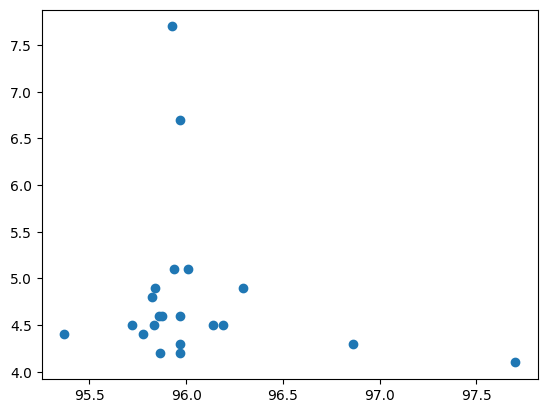

In [50]:
plt.plot(aftershock[' Longitude '],aftershock[' Magnitude '],'o')